In [13]:
# !pip install sbi

import torch
import numpy as np
from scipy.signal import welch
from sbi import utils as sbi_utils
from sbi.inference import SNPE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import load_model

In [14]:


#  Load Trained Generator
generator = load_model("saved_models/generator_52.keras")

# --- Hyperparameters ---
latent_dim = 100
num_simulations = 2000
num_test_samples = 100

#  Prior: fc ∈ [0.01, 0.5], amp ∈ [0.6, 1.0]
prior = sbi_utils.BoxUniform(low=torch.tensor(
    [0.01, 0.6]), high=torch.tensor([0.5, 1.0]))

#  GAN-based simulator for SBI


def simulator(theta):
    fc, amp = theta.numpy()
    z = torch.randn((1, latent_dim))
    label = torch.tensor([[fc, amp]], dtype=torch.float32)
    generated = generator([z, label], training=False).numpy().squeeze()
    f, Pxx = welch(generated, fs=1, nperseg=256)
    return torch.tensor(Pxx, dtype=torch.float32)


# --- Generate Simulations
print("Generating synthetic QPOs for SBI...")
thetas = prior.sample((num_simulations,))
xs = torch.stack([simulator(theta) for theta in thetas])

# --- Train SBI Posterior
inference = SNPE(prior)
density_estimator = inference.append_simulations(thetas, xs).train()
posterior = inference.build_posterior(density_estimator)

#  Save Trained Posterior
torch.save(posterior, "saved_models/trained_sbi_posterior.pt")
print(" SBI Posterior trained and saved.")

Generating synthetic QPOs for SBI...
 Neural network successfully converged after 141 epochs. SBI Posterior trained and saved.


In [18]:
import numpy as np
import torch
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns


def run_grid_sbi_evaluation(generator, posterior, latent_dim=100,
                            fc_vals=np.linspace(0.01, 0.5, 8),
                            amp_vals=np.linspace(0.6, 1.0, 8),
                            num_samples=500):
    """
    Run full-loop inference on a grid of fc/amp values and collect mean errors.
    Returns 2D arrays of errors.
    """

    fc_error_map = np.zeros((len(fc_vals), len(amp_vals)))
    amp_error_map = np.zeros((len(fc_vals), len(amp_vals)))

    for i, fc in enumerate(fc_vals):
        for j, amp in enumerate(amp_vals):
            # Step 1: Generate GAN sample
            label = torch.tensor([[fc, amp]], dtype=torch.float32)
            z = torch.randn((1, latent_dim))
            signal = generator([z, label], training=False).numpy().squeeze()

            # Step 2: Compute PSD
            f, Pxx = welch(signal, fs=1, nperseg=256)
            x_obs = torch.tensor(Pxx, dtype=torch.float32)

            # Step 3: Run SBI inference
            samples = posterior.sample(
                (num_samples,), x=x_obs, show_progress_bars=False)
            fc_pred = samples[:, 0].mean().item()
            amp_pred = samples[:, 1].mean().item()

            # Step 4: Record absolute error
            fc_error_map[i, j] = abs(fc_pred - fc)
            amp_error_map[i, j] = abs(amp_pred - amp)

    return fc_vals, amp_vals, fc_error_map, amp_error_map


def plot_error_heatmaps(fc_vals, amp_vals, fc_errs, amp_errs):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(fc_errs, xticklabels=np.round(amp_vals, 2), yticklabels=np.round(fc_vals, 2),
                ax=axs[0], cmap="Blues", annot=True)
    axs[0].set_title("FC Error Heatmap")
    axs[0].set_xlabel("Amplitude")
    axs[0].set_ylabel("FC (Hz)")

    sns.heatmap(amp_errs, xticklabels=np.round(amp_vals, 2), yticklabels=np.round(fc_vals, 2),
                ax=axs[1], cmap="Oranges", annot=True)
    axs[1].set_title("Amplitude Error Heatmap")
    axs[1].set_xlabel("Amplitude")
    axs[1].set_ylabel("FC (Hz)")

    plt.suptitle("SBI Inference Error Across FC-Amplitude Grid")
    plt.tight_layout()
    plt.show()

/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_16149/3286895218.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior = torch.load("saved_models/trained_

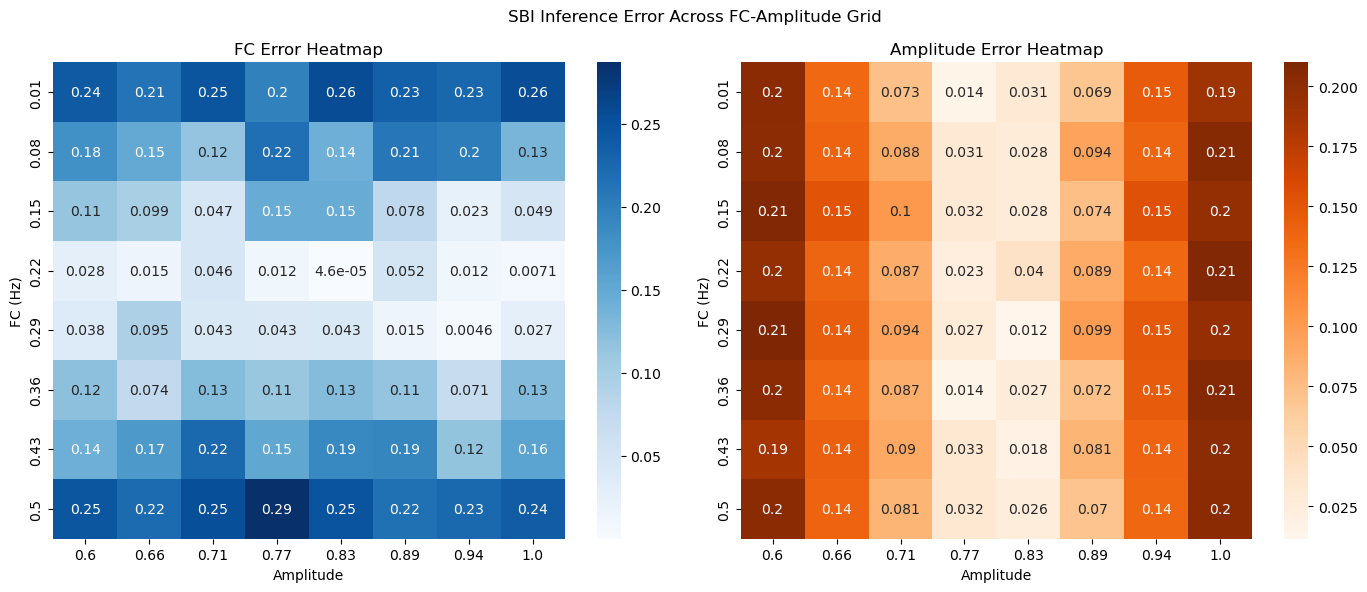

In [19]:
# Load posterior (already trained and saved)
posterior = torch.load("saved_models/trained_sbi_posterior.pt")

generator = load_model("saved_models/generator_52.keras")

fc_vals, amp_vals, fc_errs, amp_errs = run_grid_sbi_evaluation(
    generator, posterior)
plot_error_heatmaps(fc_vals, amp_vals, fc_errs, amp_errs)